<a href="https://colab.research.google.com/github/vijayarun00100/NLP/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install adjustText

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import zipfile
import re
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from adjustText import adjust_text

In [ ]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""

    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')

    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")

    extract_path = os.path.join(data_dir, 'bbc')
    if not os.path.exists(extract_path):

        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)

    else:
        print("bbc-fulltext.zip has already been extracted")

download_data(url, 'data')

In [ ]:
def read_data(data_dir):

    # This will contain the full list of stories
    news_stories = []

    print("Reading files")

    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):

        for fi, f in enumerate(files):

            # We don't read the readme file
            if 'README' in f:
                continue

            # Printing progress
            i += 1
            print("."*i, f, end='\r')

            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as f:

                story = []
                # Read all the lines
                for row in f:

                    story.append(row.strip())

                # Create a single string with all the rows in the doc
                story = ' '.join(story)
                # Add that to the list
                news_stories.append(story)

        print('', end='\r')

    print(f"\nDetected {len(news_stories)} stories")
    return news_stories


news_stories = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' '
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


In [ ]:
n_vocab = len(tokenizer.word_index.items()) + 1
print(f"Vocabulary size: {n_vocab}")

print("\nWords at the top")
print('\t', dict(list(tokenizer.word_index.items())[:10]))
print("\nWords at the bottom")
print('\t', dict(list(tokenizer.word_index.items())[-10:]))

Vocabulary size: 32360

Words at the top
	 {'the': 1, 'to': 2, 'of': 3, 'and': 4, 'a': 5, 'in': 6, 'for': 7, 'is': 8, 'that': 9, 'on': 10}

Words at the bottom
	 {"moment'": 32350, "kaplinsky's": 32351, "sharapova's": 32352, "pinsent's": 32353, 'jennie': 32354, "buerk's": 32355, 'unwell': 32356, 'savaged': 32357, 'â£77m': 32358, 'bruckheimer': 32359}


In [ ]:
print(f"Original: {news_stories[0][:100]}")
print(f"Sequence IDs: {tokenizer.texts_to_sequences([news_stories[0][:100]])[0]}")

Original: 'Hitler' row over Welsh arts cash  An artist critical of Welsh arts funding being brought under asse
Sequence IDs: [20593, 1015, 60, 1372, 2135, 570, 32, 2008, 1567, 3, 1372, 2135, 1583, 86, 894, 159]


In [ ]:
news_sequences = tokenizer.texts_to_sequences(news_stories)

In [ ]:


sample_word_ids = news_sequences[0][:5]
sample_phrase = ' '.join([tokenizer.index_word[wid] for wid in sample_word_ids])
print(f"Sample phrase: {sample_phrase}")
print(f"Sample word IDs: {sample_word_ids}\n")

window_size = 1 # How many words to consider left and right.

inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    sample_word_ids,
    vocabulary_size=n_vocab,
    window_size=window_size, negative_samples=1.0, shuffle=False,
    categorical=False, sampling_table=None, seed=None
)


print("Sample skip-grams")

for inp, lbl in zip(inputs, labels):
    print(f"\tInput: {inp} ({[tokenizer.index_word[wi] for wi in inp]}) / Label: {lbl}")

Sample phrase: 'hitler' row over welsh arts
Sample word IDs: [20593, 1015, 60, 1372, 2135]

Sample skip-grams
	Input: [20593, 1015] (["'hitler'", 'row']) / Label: 1
	Input: [1015, 20593] (['row', "'hitler'"]) / Label: 1
	Input: [1015, 60] (['row', 'over']) / Label: 1
	Input: [60, 1015] (['over', 'row']) / Label: 1
	Input: [60, 1372] (['over', 'welsh']) / Label: 1
	Input: [1372, 60] (['welsh', 'over']) / Label: 1
	Input: [1372, 2135] (['welsh', 'arts']) / Label: 1
	Input: [2135, 1372] (['arts', 'welsh']) / Label: 1
	Input: [20593, 6033] (["'hitler'", 'freddie']) / Label: 0
	Input: [1015, 26345] (['row', 'accidently']) / Label: 0
	Input: [1015, 31916] (['row', 'salles']) / Label: 0
	Input: [60, 15261] (['over', 'ethiopians']) / Label: 0
	Input: [60, 19188] (['over', 'fractious']) / Label: 0
	Input: [1372, 3977] (['welsh', 'active']) / Label: 0
	Input: [1372, 15487] (['welsh', "o'herlihy"]) / Label: 0
	Input: [2135, 2224] (['arts', 'breaking']) / Label: 0


In [ ]:
inputs, labels = tf.keras.preprocessing.sequence.skipgrams(
    sample_word_ids,
    vocabulary_size=len(tokenizer.word_index.items())+1,
    window_size=window_size, negative_samples=0, shuffle=False,
)

inputs, labels = np.array(inputs), np.array(labels)

negative_sampling_candidates, true_expected_count, sampled_expected_count = tf.random.log_uniform_candidate_sampler(
    # A true context word that appears in the context of the target
    true_classes=inputs[:1,1:], # [b, 1] sized tensor
    num_true=1, # number of true words per example
    num_sampled=10,
    unique=True,
    range_max=n_vocab,
    name="negative_sampling"
)

print(f"Positive sample: {inputs[:1,1:]}")
print(f"Negative samples: {negative_sampling_candidates}")
print(f"true_expected_count: {true_expected_count}")
print(f"sampled_expected_count: {sampled_expected_count}")

Positive sample: [[1015]]
Negative samples: [    3  3452     0    38   701    46  5388 16511    30  7700]
true_expected_count: [[0.00104156]]
sampled_expected_count: [2.1253879e-01 3.0667498e-04 5.3227150e-01 2.6493348e-02 1.5067960e-03
 2.2076128e-02 1.9652197e-04 6.4146479e-05 3.3120409e-02 1.3752951e-04]


In [ ]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(n_vocab, sampling_factor=1e-05)

print(sampling_table)

[0.00315225 0.00315225 0.00547597 ... 1.         1.         1.        ]


In [ ]:
def skip_gram_data_generator(sequences, window_size, batch_size, negative_samples, vocab_size, seed=None):

    rand_sequence_ids = np.arange(len(sequences))
    np.random.shuffle(rand_sequence_ids)


    for si in rand_sequence_ids:

        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequences[si],
            vocabulary_size=vocab_size,
            window_size=window_size,
            negative_samples=0.0,
            shuffle=False,
            sampling_table=sampling_table,
            seed=seed
        )

        targets, contexts, labels = [], [], []

        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)

            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=negative_samples,
              unique=True,
              range_max=vocab_size,
              name="negative_sampling")

            # Build context and label vectors (for one target word)
            context = tf.concat(
                [tf.constant([context_word], dtype='int64'), negative_sampling_candidates],
                axis=0
            )

            label = tf.constant([1] + [0]*negative_samples, dtype="int64")

            # Append each element from the training example to global lists.
            targets.extend([target_word]*(negative_samples+1))
            contexts.append(context)
            labels.append(label)

        contexts, targets, labels = np.concatenate(contexts), np.array(targets), np.concatenate(labels)

        assert contexts.shape[0] == targets.shape[0]
        assert contexts.shape[0] == labels.shape[0]

        # If seed is not provided generate a random one
        if not seed:
            seed = random.randint(0, 10e6)

        np.random.seed(seed)
        np.random.shuffle(contexts)
        np.random.seed(seed)
        np.random.shuffle(targets)
        np.random.seed(seed)
        np.random.shuffle(labels)


        for eg_id_start in range(0, contexts.shape[0], batch_size):
            yield (
                targets[eg_id_start: min(eg_id_start+batch_size, targets.shape[0])],
                contexts[eg_id_start: min(eg_id_start+batch_size, contexts.shape[0])]
            ), labels[eg_id_start: min(eg_id_start+batch_size, labels.shape[0])]


news_skip_gram_gen = skip_gram_data_generator(
    news_sequences, 4, 10, 5, n_vocab
)

for btc, bl in news_skip_gram_gen:

    print(btc)
    print(bl)

    break

(array([13447,  1556,   539,  1556,  3486,  1556,     4,   714,   539,
       13447]), array([ 20,  71,   7, 579,   1, 451,   6,  50,   9,   1]))
[0 0 0 1 0 0 0 0 0 0]


In [ ]:
batch_size = 4096 # Data points in a single batch

embedding_size = 128 # Dimension of the embedding vector.

window_size=1 # We use a window size of n on either side of target word
negative_samples = 4 # Number of negative samples generated per example

epochs = 5 # Number of epochs to train for

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 250

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
np.random.seed(54321)
random.seed(54321)

valid_term_ids = np.array(random.sample(range(valid_window), valid_size))
valid_term_ids = np.append(
    valid_term_ids, random.sample(range(1000, 1000+valid_window), valid_size),
    axis=0
)

In [ ]:
import tensorflow.keras.backend as K

K.clear_session()

# Inputs - skipgrams() function outputs target, context in that order
# we will use the same order
input_1 = tf.keras.layers.Input(shape=(), name='target')
input_2 = tf.keras.layers.Input(shape=(), name='context')

# Two embeddings layers are used one for the context and one for the target
context_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='context_embedding'
)
target_embedding_layer = tf.keras.layers.Embedding(
    input_dim=n_vocab, output_dim=embedding_size, name='target_embedding'
)

# Lookup outputs of the embedding layers
target_out = target_embedding_layer(input_1)
context_out = context_embedding_layer(input_2)

# Computing the dot product between the two
out = tf.keras.layers.Dot(axes=-1)([context_out, target_out])

# Defining the model
skip_gram_model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=out, name='skip_gram_model')

# Compiling the model
skip_gram_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam'
)

skip_gram_model.summary()

Model: "skip_gram_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 context (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 target (InputLayer)         [(None,)]                    0         []                            
                                                                                                  
 context_embedding (Embeddi  (None, 128)                  4142080   ['context[0][0]']             
 ng)                                                                                              
                                                                                                  
 target_embedding (Embeddin  (None, 128)                  4142080   ['target[0][0]']

In [ ]:
class ValidationCallback(tf.keras.callbacks.Callback):

    def __init__(self, valid_term_ids, model_with_embeddings, tokenizer):

        self.valid_term_ids = valid_term_ids
        self.model_with_embeddings = model_with_embeddings
        self.tokenizer = tokenizer

        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        """ Validation logic """

        # We will use context embeddings to get the most similar words
        # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
        embedding_weights = self.model_with_embeddings.get_layer("context_embedding").get_weights()[0]
        normalized_embeddings = embedding_weights / np.sqrt(np.sum(embedding_weights**2, axis=1, keepdims=True))

        # Get the embeddings corresponding to valid_term_ids
        valid_embeddings = normalized_embeddings[self.valid_term_ids, :]

        # Compute the similarity between valid_term_ids and all the embeddings
        # V x d (d x D) => V x D
        top_k = 5 # Top k items will be displayed
        similarity = np.dot(valid_embeddings, normalized_embeddings.T)

        # Invert similarity matrix to negative
        # Ignore the first one because that would be the same word as the probe word
        similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

        # Print the output
        for i, term_id in enumerate(valid_term_ids):

            similar_word_str = ', '.join([self.tokenizer.index_word[j] for j in similarity_top_k[i, :] if j >= 1])
            print(f"{self.tokenizer.index_word[term_id]}: {similar_word_str}")

        print('\n')

In [ ]:
skipgram_validation_callback = ValidationCallback(valid_term_ids, skip_gram_model, tokenizer)

for ei in range(epochs):

    print(f"Epoch: {ei+1}/{epochs} started")

    news_skip_gram_gen = skip_gram_data_generator(
        news_sequences, window_size, batch_size, negative_samples, n_vocab
    )

    skip_gram_model.fit(
        news_skip_gram_gen, epochs=1,
        callbacks=skipgram_validation_callback,
    )



Epoch: 1/5 started
   2234/Unknown - 162s 72ms/step - loss: 0.5994labour: end, way, lot, do
own: reveal, uk, many, lack
as: wants, so, rbs, own, too
last: next, slowly, claim, cope
also: made, able, lot, yet, there
since: rbs, begins, brixton, write, 2002
much: soon, built, part, set
should: able, lot, may, calls
year: slowly, 3g, few, month, december
around: write, lot, able, agree
only: lot, going, way, find
going: way, find, do, trying
economy: way, designed, go, lot
what: lot, able, do, how
minister: minister's, deputy, selling, fifa, proposes
they: you, there, we, it, she
post: cynical, money, frustrating, wrong, arsenal
pair: want, way, fear, find
trading: embrace, apologise, 71, government, lot
critics: need, lot, see, continue
positive: perhaps, couple, according, look, hands
central: pilot, due, india, aviator, claim
judge: 21st, end, see, lot
states: go, claim, do, win
measures: investments, whether, work, couple, tens
question: tipped, cynical, proposals, put, expected
attem

In [ ]:
def save_embeddings(model, tokenizer, vocab_size, save_dir):

    os.makedirs(save_dir, exist_ok=True)

    _, words_sorted = zip(*sorted(list(tokenizer.index_word.items()), key=lambda x: x[0])[:vocab_size-1])

    words_sorted = [None] + list(words_sorted)

    pd.DataFrame(
        model.get_layer("context_embedding").get_weights()[0],
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "context_embedding.pkl"))

    pd.DataFrame(
        model.get_layer("target_embedding").get_weights()[0],
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "target_embedding.pkl"))


save_embeddings(skip_gram_model, tokenizer, n_vocab, save_dir='skipgram_embeddings')

In [ ]:
skipgram_context_embeddings = pd.read_pickle(
    os.path.join('skipgram_embeddings', 'context_embedding.pkl')
)

skipgram_words, skipgram_embeddings = np.array(skipgram_context_embeddings.index), skipgram_context_embeddings.values

In [ ]:
def find_clustered_embeddings(embeddings, top_n=10, top_words=2000):
    '''
    Find only the closely clustered embeddings.
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization

    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''

    # calculate cosine similarity
    embeddings_norm = embeddings / np.sum(embeddings**2, keepdims=True, axis=1)
    cosine_sim = np.dot(embeddings, embeddings.T)

    sim_sum_words = np.sum(np.sort(cosine_sim, axis=1)[:,-top_n:], axis=1)

    clustered_words = np.argsort(-sim_sum_words)[:top_words]


    return clustered_words

In [ ]:
import sklearn


tsne = TSNE(
    perplexity=30, n_components=2, n_iter=5000, metric='cosine')

print('Fitting embeddings to T-SNE. This can take some time ...')
# get the T-SNE manifold

# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
plot_word_ids = find_clustered_embeddings(
    skipgram_embeddings, top_n=25, top_words=300
)


skipgram_embeddings_norm = skipgram_embeddings / np.sum(skipgram_embeddings**2, keepdims=True, axis=1)
tsne_embeddings = tsne.fit_transform(skipgram_embeddings_norm)

print('Pruning the T-SNE embeddings')

print('\tDone')

Fitting embeddings to T-SNE. This can take some time ...
Pruning the T-SNE embeddings
	Done


Plotting 1500 points
Adjusting text annotations in the plot. This may take some time: Annotations 342


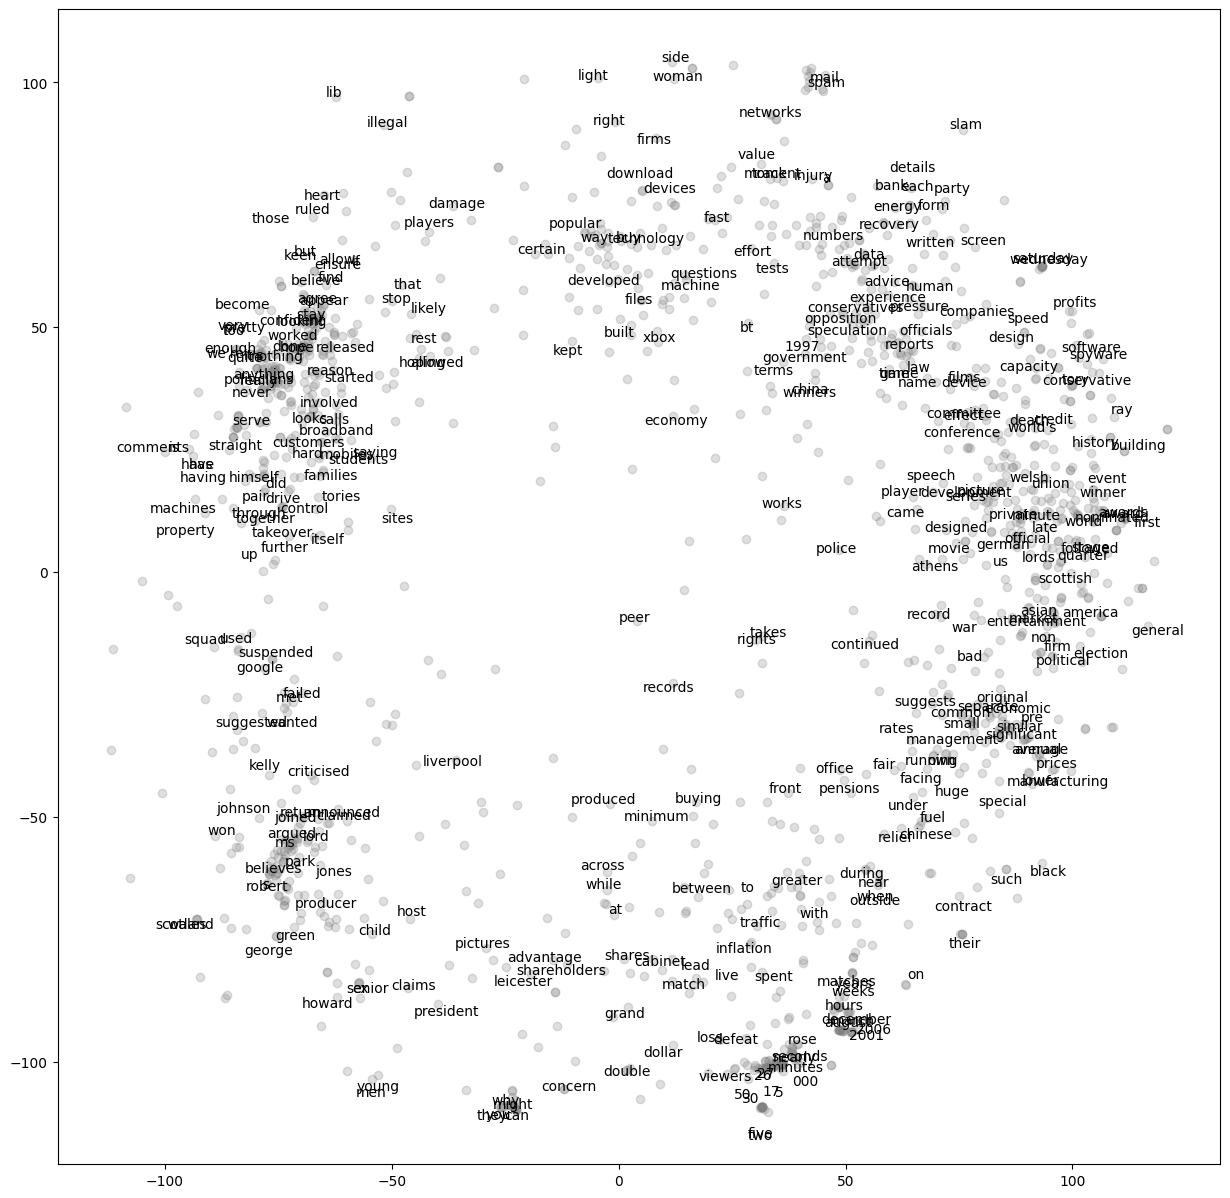

In [ ]:
def plot(embeddings, labels):
    print(f"Plotting {embeddings.shape[0]} points")
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(15,15))  # in inches

    # plot all the embeddings and their corresponding words
    plot_annotations = []

    for i, label in enumerate(labels):

        x, y = embeddings[i,:]
        plt.scatter(x, y, alpha=0.25, c='gray')

        # We only annotate a small fraction of data, to avoid long waiting times
        if np.random.normal()>0.75:
            plot_annotations.append(
                plt.text(x, y, label, ha='center', va='center', fontsize=10)
            )

    print(
        f"Adjusting text annotations in the plot. This may take some time: Annotations {len(plot_annotations)}"
    )
    adjust_text(plot_annotations)

    # use for saving the figure if needed
    #plt.savefig('word_embeddings.png')
    plt.show()


plot(tsne_embeddings[1:1501], skipgram_words[1:1501])